In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder
import time
import pickle
import psutil

In [2]:
#Read product names and IDs
lines=open("products.txt", "rt", encoding="utf8").readlines()
prod_dict={}
products=[0]*len(lines)
for lin in lines[1:]:
    pid, pname, aid, did=lin.strip().split("\t")    
    products[int(pid)]=pname
    prod_dict[pid] = pname

In [3]:
prods = products[1:]

In [4]:
"""#read transactions
import pickle
orders=pickle.load(open("order_products.pickle", "rb"))

#check products on order 2:
for prod in orders[2]: print(products[prod])"""

'#read transactions\nimport pickle\norders=pickle.load(open("order_products.pickle", "rb"))\n\n#check products on order 2:\nfor prod in orders[2]: print(products[prod])'

In [6]:
# Load the transaction dataset from a pickle file
with open("order_products.pickle", "rb") as f:
    orders = pickle.load(f)

# Convert the transaction data into a list of lists
orders_list = [list(order) for order in orders.values()]

In [7]:
# Encode the transaction data as a binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(orders_list, sparse=True)

In [8]:
df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)

In [9]:
df.columns = [prod_dict[str(key)] for key in df.columns]

In [10]:
from sys import getsizeof

print(f"Size of orders {getsizeof(orders)/1024/1024} MB")
print(f"Size of orders_list {getsizeof(orders_list)/1024/1024} MB")
print(f"Size of te_ary {getsizeof(te_ary)/1024/1024} MB")
print(f"Size of product_dict {getsizeof(prod_dict)/1024/1024} MB")
print(f"Size of products {getsizeof(products)/1024/1024} MB")

Size of orders 160.00009155273438 MB
Size of orders_list 26.16533660888672 MB
Size of te_ary 4.57763671875e-05 MB
Size of product_dict 2.500091552734375 MB
Size of products 0.379150390625 MB


In [11]:
orders = None
orders_list = None


In [75]:
print(f"Size of orders {round(getsizeof(orders)/1024/1024, 4)} MB")
print(f"Size of orders_list {round(getsizeof(orders_list)/1024/1024, 4)} MB")

Size of orders 0.0 MB
Size of orders_list 0.0 MB


In [18]:
#Here is the main search for the minimum support, took hours to fully run. Don't run again.

min_support = 0.0
increment = 0.0
max_time = 60*60*2 # 2 hours in seconds
starting_support = [0.1, 0.01, 0.001, 0.0001, 0.00001]
cont = True

#Creae and open a file to write the results
with open("min_support2.txt", "w") as f:
    for i in range(len(starting_support)):
        if round(min_support, 6) == 0.0:
            min_support = starting_support[i]
            increment = starting_support[i]/10
            cont = True
        else:
            continue
        while cont == True:
            start_time = time.time()
            frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, low_memory=True)
            #Save the frequent itemsets to a csv file
            frequent_itemsets.to_csv('frequent_itemsets3.csv', index=False)
            end_time = time.time()
            memory_usage = frequent_itemsets.memory_usage(deep=True).sum()
            total_memory = psutil.virtual_memory().available
            elapsed_time = end_time - start_time

            #Record the results and save to file
            f.write('Minimum support: {:.3f}, Time: {:.3f} s, FI Mem usage: {:.3f}MB, Total Mem usage: {:.3f}MB\n'.format(round(min_support, 6), elapsed_time, memory_usage/1024/1024, total_memory/1024/1024))
            f.write(f"{round(min_support, 6)}\n")
            print('Minimum support: {:.3f}, Time: {:.3f} s, FI Mem usage: {:.3f}MB, Total Mem usage: {:.3f}MB'.format(round(min_support, 6), elapsed_time, memory_usage/1024/1024, total_memory/1024/1024))
            
            min_support -= increment
            if round(min_support, 6) == 0.0:
                cont = False
            
            print(f"Continue: {cont}")
            if elapsed_time > max_time:
                print(f"Minimum support: {round(min_support, 6)} exceeded time limit")
                break



0.1
Minimum support: 0.100, Time: 1.455 s, FI Mem usage: 0.001MB, Total Mem usage: 1106.996MB
Continue: True
0.09000000000000001
Minimum support: 0.090, Time: 1.005 s, FI Mem usage: 0.001MB, Total Mem usage: 1141.691MB
Continue: True
0.08000000000000002
Minimum support: 0.080, Time: 1.035 s, FI Mem usage: 0.001MB, Total Mem usage: 1124.422MB
Continue: True
0.07000000000000002
Minimum support: 0.070, Time: 1.009 s, FI Mem usage: 0.001MB, Total Mem usage: 1132.938MB
Continue: True
0.06000000000000002
Minimum support: 0.060, Time: 1.085 s, FI Mem usage: 0.001MB, Total Mem usage: 1129.910MB
Continue: True
0.05000000000000002
Minimum support: 0.050, Time: 1.059 s, FI Mem usage: 0.001MB, Total Mem usage: 1162.582MB
Continue: True
0.040000000000000015
Minimum support: 0.040, Time: 1.191 s, FI Mem usage: 0.002MB, Total Mem usage: 1131.168MB
Continue: True
0.030000000000000013
Minimum support: 0.030, Time: 1.282 s, FI Mem usage: 0.003MB, Total Mem usage: 1149.531MB
Continue: True
0.020000000000

In [19]:
with open("min_support.txt", "r") as f:    
    #Store the lines in a list
    lines = f.readlines()
    #Get the last line without \n
    min_sup = float(lines[-1].rstrip())
    print(f"Minimum support: {min_sup}")
    
    min_sups = [float(lines[i].split()[2].replace(',', '')) for i in range(0, len(lines), 2)]

    times = [float(lines[i].split()[4].replace(',', '')) for i in range(0, len(lines), 2)]

    mem_usage = [float(lines[i].split()[9].replace('MB,', '')) for i in range(0, len(lines), 2)]

In [70]:
import plotly.graph_objects as go

fig = go.Figure()

# Add the time and memory usage data to the first and second y-axis
fig.add_trace(go.Scatter(x=min_sups, y=times, name='Time'))
fig.add_trace(go.Scatter(x=min_sups, y=mem_usage, name='Memory Usage', yaxis='y2'))

# Set the layout for the figure
fig.update_layout(
    title='Time and Memory Usage vs. Minimum Support', xaxis_title='Minimum Support', yaxis=dict(title='Time (s)'),
    yaxis2=dict(title='Memory Usage (MB)', overlaying='y', side='right'))

# Reverse the x-axis
fig.update_xaxes(autorange='reversed')
fig.update_layout(template='ggplot2')

fig.show()


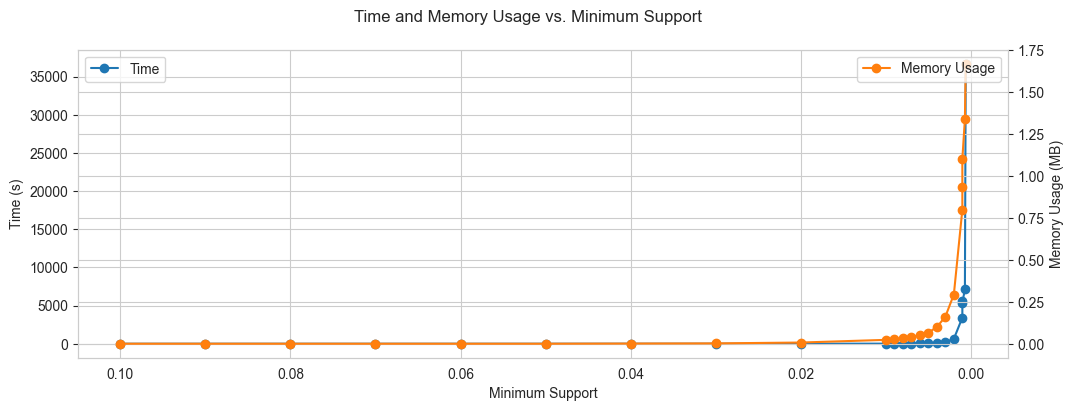

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new figure
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 4)

# Add the time data to the first y-axis
ax1.plot(min_sups, times, label='Time', color='tab:blue', marker='o')
ax1.set_xlabel('Minimum Support')
ax1.set_ylabel('Time (s)')

# Create a second y-axis and add the memory usage data
ax2 = ax1.twinx()
ax2.plot(min_sups, mem_usage, label='Memory Usage', color='tab:orange', marker='o')
ax2.set_ylabel('Memory Usage (MB)')

# Set the layout for the figure
fig.suptitle('Time and Memory Usage vs. Minimum Support')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
sns.set_style('whitegrid')

# Reverse the x-axis
ax1.invert_xaxis()
plt.show()


In [63]:
import ast
fi = pd.read_csv('frequent_itemsets3.csv')

#Convert itemsets from strings to back to frozenset
for i in range(0, len(fi["itemsets"])):
    # Remove the 'frozenset()' part from the string
    line = fi["itemsets"][i].replace("frozenset(", "").replace(')', '')
    # Convert the remaining string to a frozenset using ast.literal_eval
    fi["itemsets"][i] = frozenset(ast.literal_eval(line))

/var/folders/hw/n2l_r7sj3fj2mg88w0q6fpcc0000gn/T/ipykernel_58473/3159491617.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [65]:
fi['length'] = fi['itemsets'].apply(lambda x: len(x))
fi

,support,itemsets,length
0,0.000800,(Sparkling Orange Juice & Prickly Pear Beverage),1
1,0.000674,(Salted Caramel Lean Protein & Fiber Bar),1
2,0.002033,(Peanut Butter Cereal),1
3,0.005727,(European Cucumber),1
4,0.000718,(Vegetarian Grain Meat Sausages Italian - 4 CT),1
...,...,...,...
8094,0.000624,"(Bag of Organic Bananas, Organic Hass Avocado,...",4
8095,0.000725,"(Organic Raspberries, Bag of Organic Bananas, ...",4
8096,0.000618,"(Banana, Organic Avocado, Organic Baby Spinach...",4
8097,0.000714,"(Banana, Organic Avocado, Organic Baby Spinach...",4


In [72]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Zero Calorie Cola),(Soda),0.002662,0.011133,0.001235,0.463893,41.668546,0.001205,1.844535
1,(Garnet Sweet Potato (Yam)),(Banana),0.002095,0.146993,0.000656,0.313140,2.130303,0.000348,1.241894
2,(Mango Chunks),(Banana),0.005505,0.146993,0.001745,0.316911,2.155952,0.000935,1.248748
3,(Cherry Pomegranate Greek Yogurt),(Banana),0.002133,0.146993,0.000666,0.312336,2.124831,0.000353,1.240441
4,(Organic Greek Lowfat Yogurt With Strawberries),(Organic Greek Lowfat Yogurt With Blueberries),0.001963,0.001486,0.000609,0.310410,208.946882,0.000606,1.447984
...,...,...,...,...,...,...,...,...,...
494,"(Organic Avocado, Organic Baby Spinach, Organi...",(Banana),0.001616,0.146993,0.000618,0.382602,2.602853,0.000381,1.381616
495,"(Organic Avocado, Organic Baby Spinach, Large ...",(Banana),0.001821,0.146993,0.000714,0.392277,2.668675,0.000447,1.403612
496,"(Banana, Organic Baby Spinach, Large Lemon)",(Organic Avocado),0.002252,0.054999,0.000714,0.317083,5.765251,0.000590,1.383772
497,"(Banana, Organic Avocado, Limes)",(Large Lemon),0.002261,0.047485,0.000706,0.312147,6.573657,0.000598,1.384767


In [73]:
sorted_rules = rules.sort_values(by=['confidence'], ascending=False)
relevant_rules = sorted_rules[sorted_rules['confidence'] >= 0.8]
sorted_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
472,"(Lime Sparkling Water, Peach Pear Flavored Spa...",(Sparkling Water Grapefruit),0.001312,0.023605,0.000850,0.648174,27.459601,0.000819,2.775226
372,"(Peach Pear Flavored Sparkling Water, Sparklin...",(Sparkling Water Grapefruit),0.001019,0.023605,0.000649,0.636253,26.954539,0.000624,2.684268
342,"(Sparkling Water Berry, Lime Sparkling Water)",(Sparkling Water Grapefruit),0.001308,0.023605,0.000827,0.632105,26.778810,0.000796,2.654003
119,(Total 2% Lowfat Greek Strained Yogurt With Bl...,(Total 2% with Strawberry Lowfat Greek Straine...,0.001218,0.009298,0.000748,0.614147,66.049092,0.000737,2.567563
339,"(Sparkling Water Berry, Sparkling Lemon Water)",(Sparkling Water Grapefruit),0.001174,0.023605,0.000711,0.605988,25.672405,0.000684,2.478087
...,...,...,...,...,...,...,...,...,...
132,"(100% Whole Wheat Bread, Organic Strawberries)",(Bag of Organic Bananas),0.002656,0.118030,0.000799,0.300738,2.547988,0.000485,1.261287
478,(Total 2% Lowfat Greek Strained Yogurt with Pe...,(Total 2% Greek Strained Yogurt with Cherry 5....,0.002493,0.005613,0.000749,0.300599,53.557291,0.000735,1.421770
185,"(Broccoli Crown, Large Lemon)",(Organic Avocado),0.002115,0.054999,0.000636,0.300544,5.464532,0.000519,1.351051
62,(YoKids Strawberry Banana/Strawberry Yogurt),(Banana),0.002096,0.146993,0.000630,0.300341,2.043231,0.000321,1.219175
